In [2]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import datetime
import geopandas as gpd
import requests
import os
import zipfile

path = Path('data')

In [3]:
data = pd.read_csv(path/'metadata.csv')
data

,uid,latitude,longitude,date,split
0,aabm,39.080319,-86.430867,2018-05-14,train
1,aabn,36.559700,-121.510000,2016-08-31,test
2,aacd,35.875083,-78.878434,2020-11-19,train
3,aaee,35.487000,-79.062133,2016-08-24,train
4,aaff,38.049471,-99.827001,2019-07-23,train
...,...,...,...,...,...
23565,zzvv,36.708500,-121.749000,2014-12-02,test
23566,zzwo,39.792190,-99.971050,2017-06-19,train
23567,zzwq,35.794000,-79.012551,2015-03-24,train
23568,zzyb,35.742000,-79.238600,2016-11-21,train


In [4]:
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.longitude, data.latitude), crs=4326)
gdf

,uid,latitude,longitude,date,split,geometry
0,aabm,39.080319,-86.430867,2018-05-14,train,POINT (-86.43087 39.08032)
1,aabn,36.559700,-121.510000,2016-08-31,test,POINT (-121.51000 36.55970)
2,aacd,35.875083,-78.878434,2020-11-19,train,POINT (-78.87843 35.87508)
3,aaee,35.487000,-79.062133,2016-08-24,train,POINT (-79.06213 35.48700)
4,aaff,38.049471,-99.827001,2019-07-23,train,POINT (-99.82700 38.04947)
...,...,...,...,...,...,...
23565,zzvv,36.708500,-121.749000,2014-12-02,test,POINT (-121.74900 36.70850)
23566,zzwo,39.792190,-99.971050,2017-06-19,train,POINT (-99.97105 39.79219)
23567,zzwq,35.794000,-79.012551,2015-03-24,train,POINT (-79.01255 35.79400)
23568,zzyb,35.742000,-79.238600,2016-11-21,train,POINT (-79.23860 35.74200)


<AxesSubplot: >

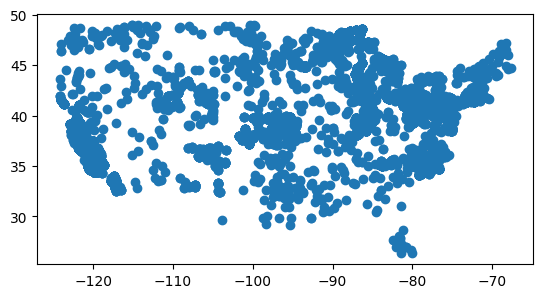

In [5]:
gdf.plot()

In [6]:
gdf.to_crs(epsg=3174, inplace=True)
gdf.geometry = gdf.geometry.apply(lambda x: x.buffer(1000))
gdf.to_crs(epsg=4326, inplace=True)
gdf['aoi'] = gdf.geometry.apply(lambda x: x.bounds)
gdf

,uid,latitude,longitude,date,split,geometry,aoi
0,aabm,39.080319,-86.430867,2018-05-14,train,"POLYGON ((-86.41936 39.08054, -86.41939 39.079...","(-86.44237240328485, 39.07127679937077, -86.41..."
1,aabn,36.559700,-121.510000,2016-08-31,test,"POLYGON ((-121.50009 36.56374, -121.49965 36.5...","(-121.52106383044192, 36.55060968929921, -121...."
2,aacd,35.875083,-78.878434,2020-11-19,train,"POLYGON ((-78.86751 35.87445, -78.86763 35.873...","(-78.8893849562264, 35.865977104938636, -78.86..."
3,aaee,35.487000,-79.062133,2016-08-24,train,"POLYGON ((-79.05127 35.48639, -79.05139 35.485...","(-79.0730197019598, 35.47788529318353, -79.051..."
4,aaff,38.049471,-99.827001,2019-07-23,train,"POLYGON ((-99.81588 38.05119, -99.81573 38.050...","(-99.83832560202976, 38.040407267469824, -99.8..."
...,...,...,...,...,...,...,...
23565,zzvv,36.708500,-121.749000,2014-12-02,test,"POLYGON ((-121.73908 36.71257, -121.73864 36.7...","(-121.76008975169917, 36.69941217972001, -121...."
23566,zzwo,39.792190,-99.971050,2017-06-19,train,"POLYGON ((-99.95963 39.79392, -99.95946 39.793...","(-99.98269045808449, 39.78315667642313, -99.95..."
23567,zzwq,35.794000,-79.012551,2015-03-24,train,"POLYGON ((-79.00163 35.79338, -79.00176 35.792...","(-79.02348762844797, 35.78489241683781, -79.00..."
23568,zzyb,35.742000,-79.238600,2016-11-21,train,"POLYGON ((-79.22769 35.74141, -79.22781 35.740...","(-79.24952780940063, 35.73289200956001, -79.22..."


## S2L1C GEE

In [7]:
import ee
ee.Authenticate()
ee.Initialize()


Successfully saved authorization token.


In [9]:
def download_image(args):
	uid, aoi, date = args
	folder = f'data/s2/{uid}'
	if not os.path.exists(folder):
		aoi = ee.Geometry.Rectangle(aoi) 
		start_date = date
		end_date = datetime.datetime.strptime(start_date, '%Y-%m-%d') + datetime.timedelta(days=10)
		end_date = end_date.strftime('%Y-%m-%d')
		im = (ee.ImageCollection('COPERNICUS/S2_HARMONIZED') # L1C
			.filterBounds(aoi) # 64 x 64 px
			.filterDate(start_date, end_date)
			.select(['B2', 'B3', 'B4'])).first() # RGB
		try:
			link = im.getDownloadURL({
				'scale': 10,
				'crs': 'EPSG:4326',
				'fileFormat': 'GeoTIFF',
				'region': aoi
			})
			filepath = f'{uid}.zip'
			r = requests.get(link)
			with open(filepath, 'wb') as f:
				f.write(r.content)
			with zipfile.ZipFile(filepath, 'r') as zip_ref:
				zip_ref.extractall(folder)
			os.remove(filepath)
		except:
			pass

In [10]:
args = []
for row, sample in gdf.iterrows():
	args.append((sample.uid, sample.aoi, sample.date))

len(args)

23570

In [11]:
from concurrent.futures import ProcessPoolExecutor
import multiprocessing
from tqdm import tqdm 

num_cores = multiprocessing.cpu_count()
with ProcessPoolExecutor(max_workers=num_cores) as pool:
    with tqdm(total=len(args)) as progress:
        futures = []

        for arg in args:
            future = pool.submit(download_image, arg) # enviamos la tupla de argumentos
            future.add_done_callback(lambda p: progress.update())
            futures.append(future)

        results = []
        for future in futures:
            result = future.result()
            results.append(result)

 14%|█▍        | 3348/23570 [10:08<1:01:16,  5.50it/s] 
